# 머신러닝 상품화 - 여정3
## # Modeling - Classification example

In [23]:
# python 3.11
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTEENN

base_path = os.getcwd()

In [3]:
df = pd.read_csv(base_path + "/data/HR-Employee-Attrition.csv")
target_column = "Attrition"

print(df.shape)
df.head()

(1470, 35)


Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

### 1. 기초통계 및 시각화

In [4]:
# categorical and numeric columns
rsts = []
for column_name in list(df.columns):
    if(column_name==target_column): continue
    rsts.append([column_name, df[column_name].dtype, len(df[column_name].unique())])

info = pd.DataFrame(rsts, columns=['col_name','type','unique_cnt'])
info = info.loc[(info['unique_cnt']>1)&(info['unique_cnt']!=len(df))]
info

col_name    type  unique_cnt
0                        Age   int64          43
1             BusinessTravel  object           3
2                  DailyRate   int64         886
3                 Department  object           3
4           DistanceFromHome   int64          29
5                  Education   int64           5
6             EducationField  object           6
9    EnvironmentSatisfaction   int64           4
10                    Gender  object           2
11                HourlyRate   int64          71
12            JobInvolvement   int64           4
13                  JobLevel   int64           5
14                   JobRole  object           9
15           JobSatisfaction   int64           4
16             MaritalStatus  object           3
17             MonthlyIncome   int64        1349
18               MonthlyRate   int64        1427
19        NumCompaniesWorked   int64          10
21                  OverTime  object           2
22         PercentSalaryHike   int64          15
23         PerformanceRating   int64           2
24  RelationshipSatisfaction   int64           4
26          StockOptionLevel   int64           4
27         TotalWorkingYears   int64          40
28     TrainingTimesLastYear   int64           7
29           WorkLifeBalance   int64           4
30            YearsAtCompany   int64          37
31        YearsInCurrentRole   int64          19
32   YearsSinceLastPromotion   int64          16
33      YearsWithCurrManager   int64          18

In [5]:
# credit 데이터의 categoriacl data 기준
k = 9
list_numerical_column = list(info.loc[info['unique_cnt']>k,'col_name'])
list_categorical_column = [x for x in info['col_name'] if (x not in list_numerical_column)&(x!=target_column)]
for column_name in list_categorical_column:
  df[column_name] = df[column_name].astype("object")

print('# categorical data 기준 :', k)
print('numerical data: ', list_numerical_column)
print('categorical data: ', list_categorical_column)

# categorical data 기준 : 9
numerical data:  ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
categorical data:  ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance']


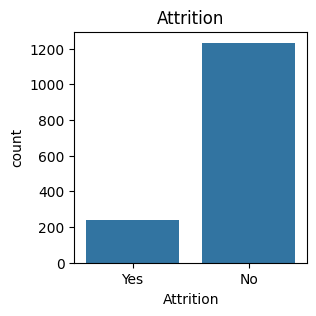

In [6]:
# 종속변수 시각화
plt.figure(figsize=(3,3))
plt.title(target_column)

sns.countplot(x=target_column, data=df)
plt.show()

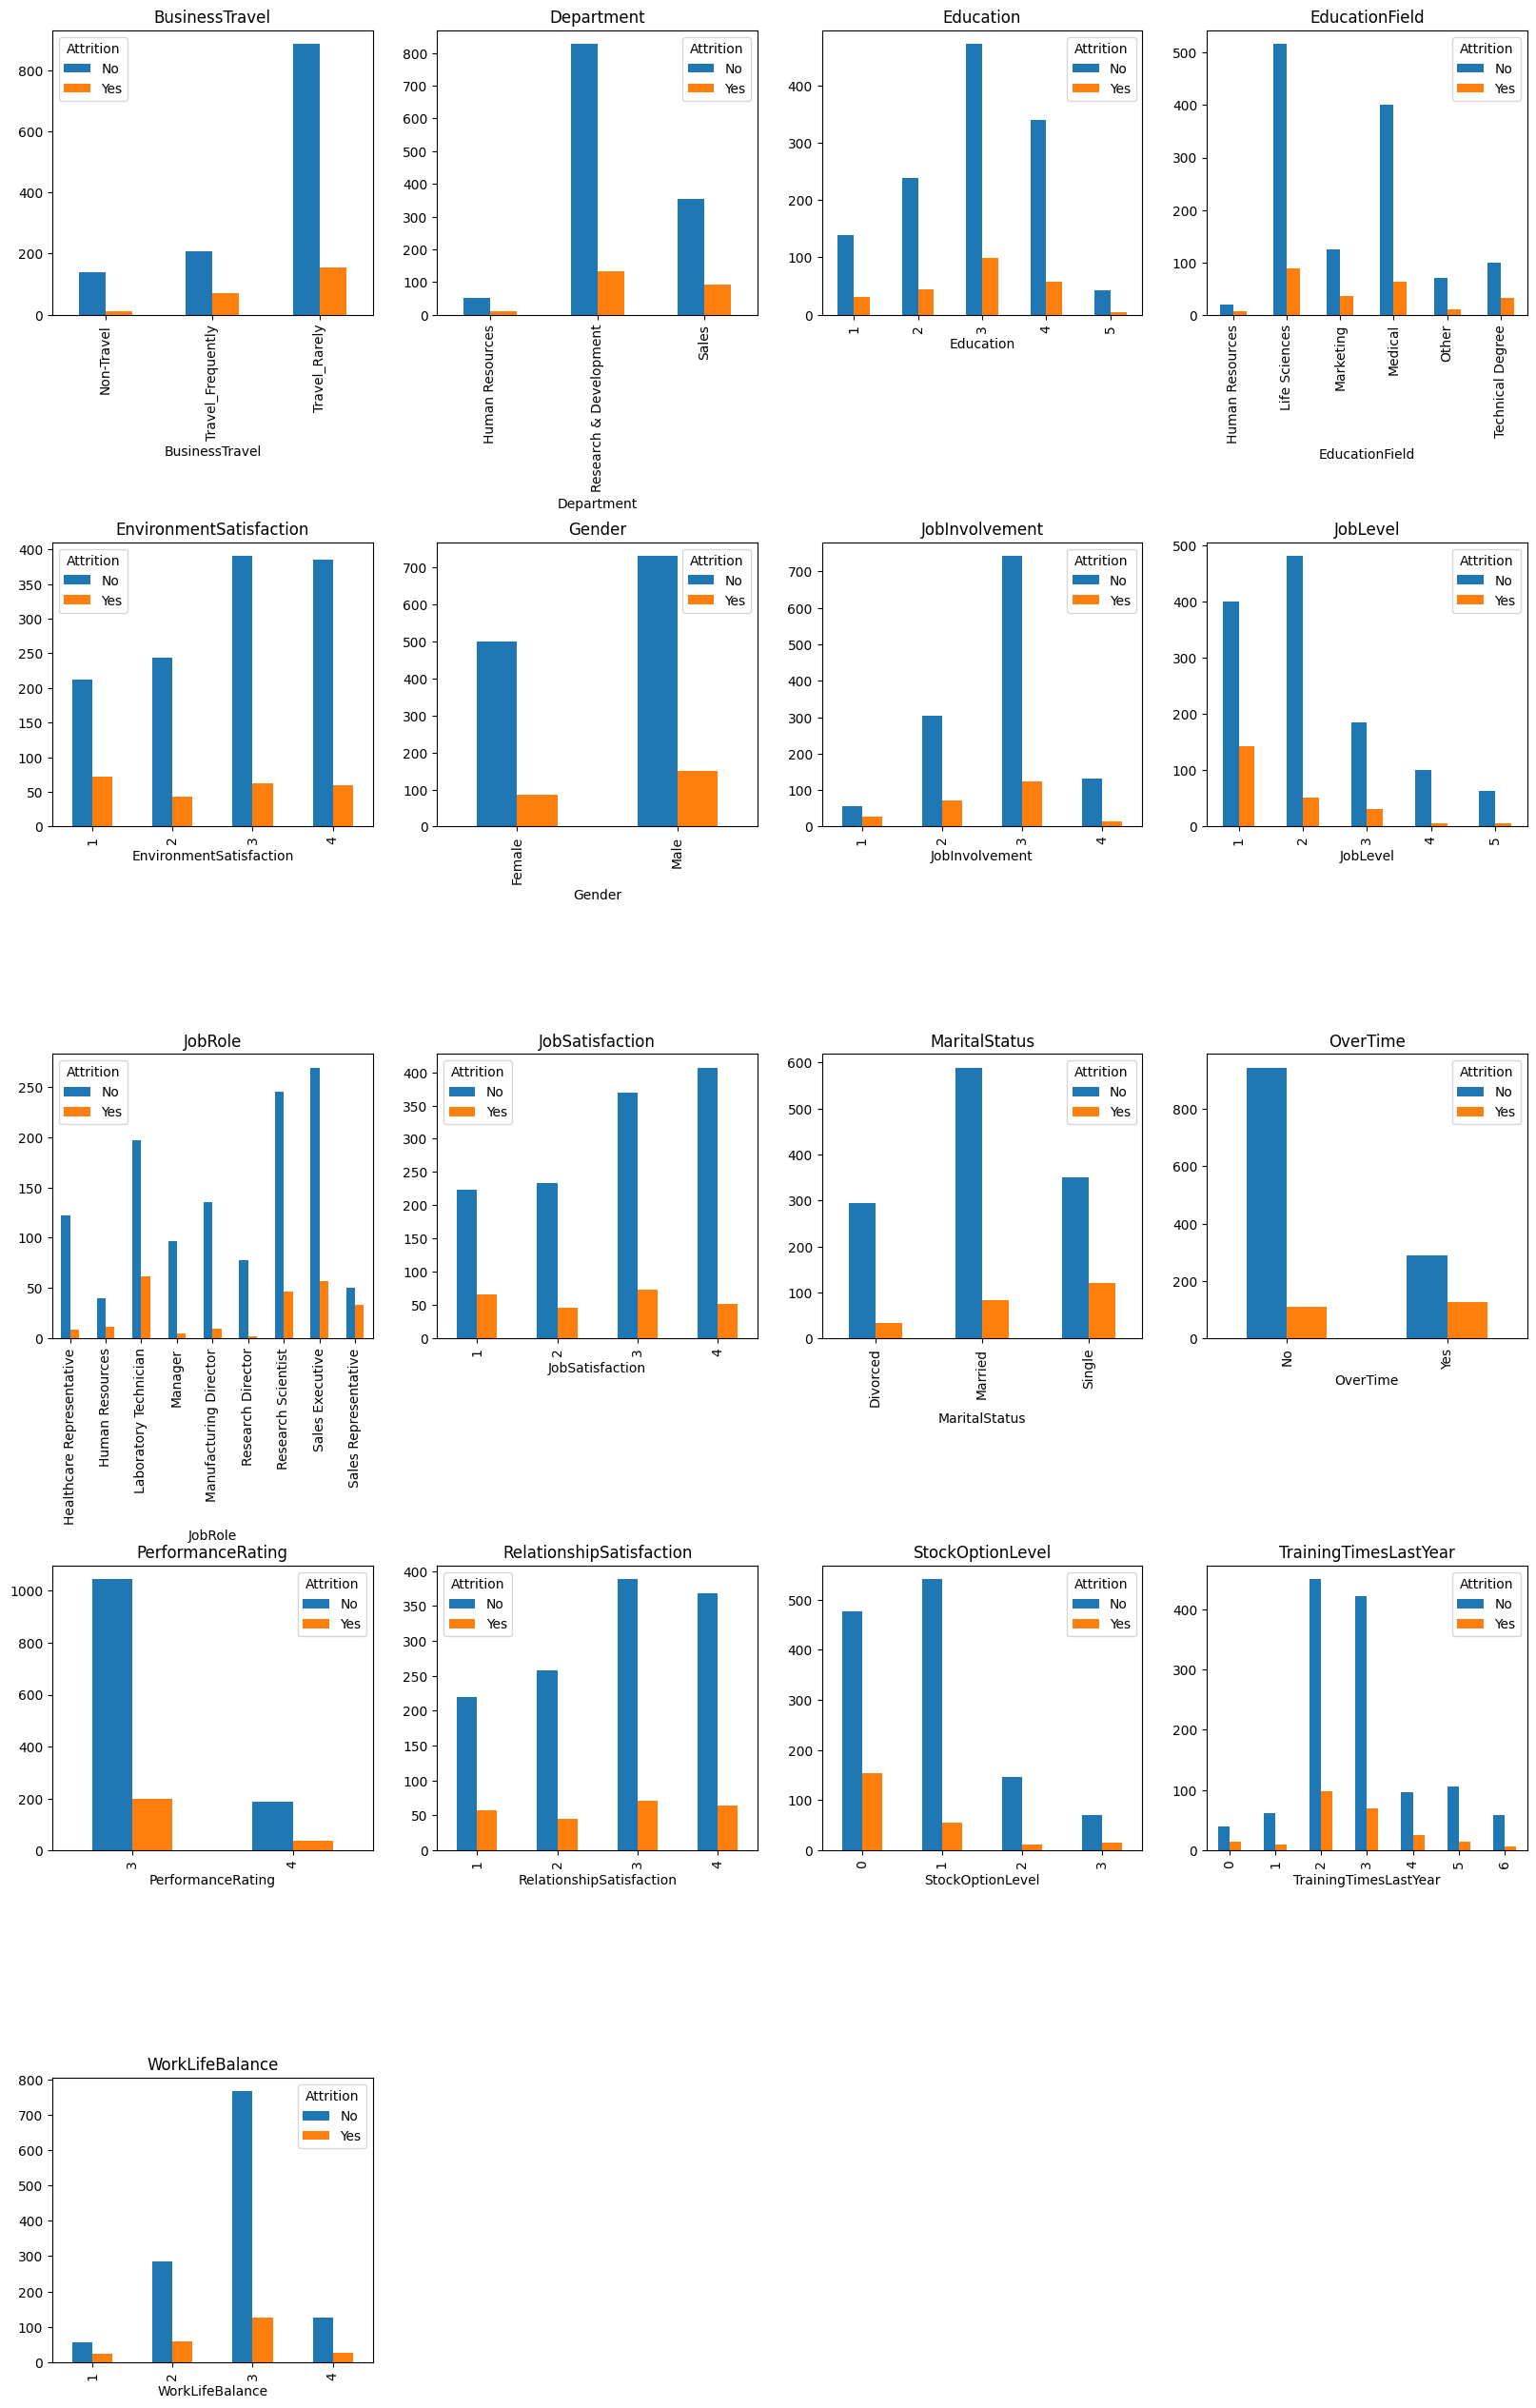

In [7]:
# 독립변수 - categorical data with target
plt.figure(figsize=(20,25))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_column:
    if(column_name==target_column):continue
    tmp_ax = plt.subplot(5,4,x)
    x = x+1
    tmp_df = df[[target_column,column_name]].groupby(by=[target_column,column_name], as_index=False).value_counts()
    tmp_df = tmp_df.pivot(index=column_name, columns=target_column, values='count')
    tmp_df.plot.bar(ax=tmp_ax)
    plt.title(column_name)

plt.show()

In [8]:
# 독립변수 - Numerical Data
df[list_numerical_column].describe()

Age    DailyRate  DistanceFromHome   HourlyRate  MonthlyIncome  \
count  1470.000000  1470.000000       1470.000000  1470.000000    1470.000000   
mean     36.923810   802.485714          9.192517    65.891156    6502.931293   
std       9.135373   403.509100          8.106864    20.329428    4707.956783   
min      18.000000   102.000000          1.000000    30.000000    1009.000000   
25%      30.000000   465.000000          2.000000    48.000000    2911.000000   
50%      36.000000   802.000000          7.000000    66.000000    4919.000000   
75%      43.000000  1157.000000         14.000000    83.750000    8379.000000   
max      60.000000  1499.000000         29.000000   100.000000   19999.000000   

        MonthlyRate  NumCompaniesWorked  PercentSalaryHike  TotalWorkingYears  \
count   1470.000000         1470.000000        1470.000000        1470.000000   
mean   14313.103401            2.693197          15.209524          11.279592   
std     7117.786044            2.498009           3.659938           7.780782   
min     2094.000000            0.000000          11.000000           0.000000   
25%     8047.000000            1.000000          12.000000           6.000000   
50%    14235.500000            2.000000          14.000000          10.000000   
75%    20461.500000            4.000000          18.000000          15.000000   
max    26999.000000            9.000000          25.000000          40.000000   

       YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
count     1470.000000         1470.000000              1470.000000   
mean         7.008163            4.229252                 2.187755   
std          6.126525            3.623137                 3.222430   
min          0.000000            0.000000                 0.000000   
25%          3.000000            2.000000                 0.000000   
50%          5.000000            3.000000                 1.000000   
75%          9.000000            7.000000                 3.000000   
max         40.000000           18.000000                15.000000   

       YearsWithCurrManager  
count           1470.000000  
mean               4.123129  
std                3.568136  
min                0.000000  
25%                2.000000  
50%                3.000000  
75%                7.000000  
max               17.000000

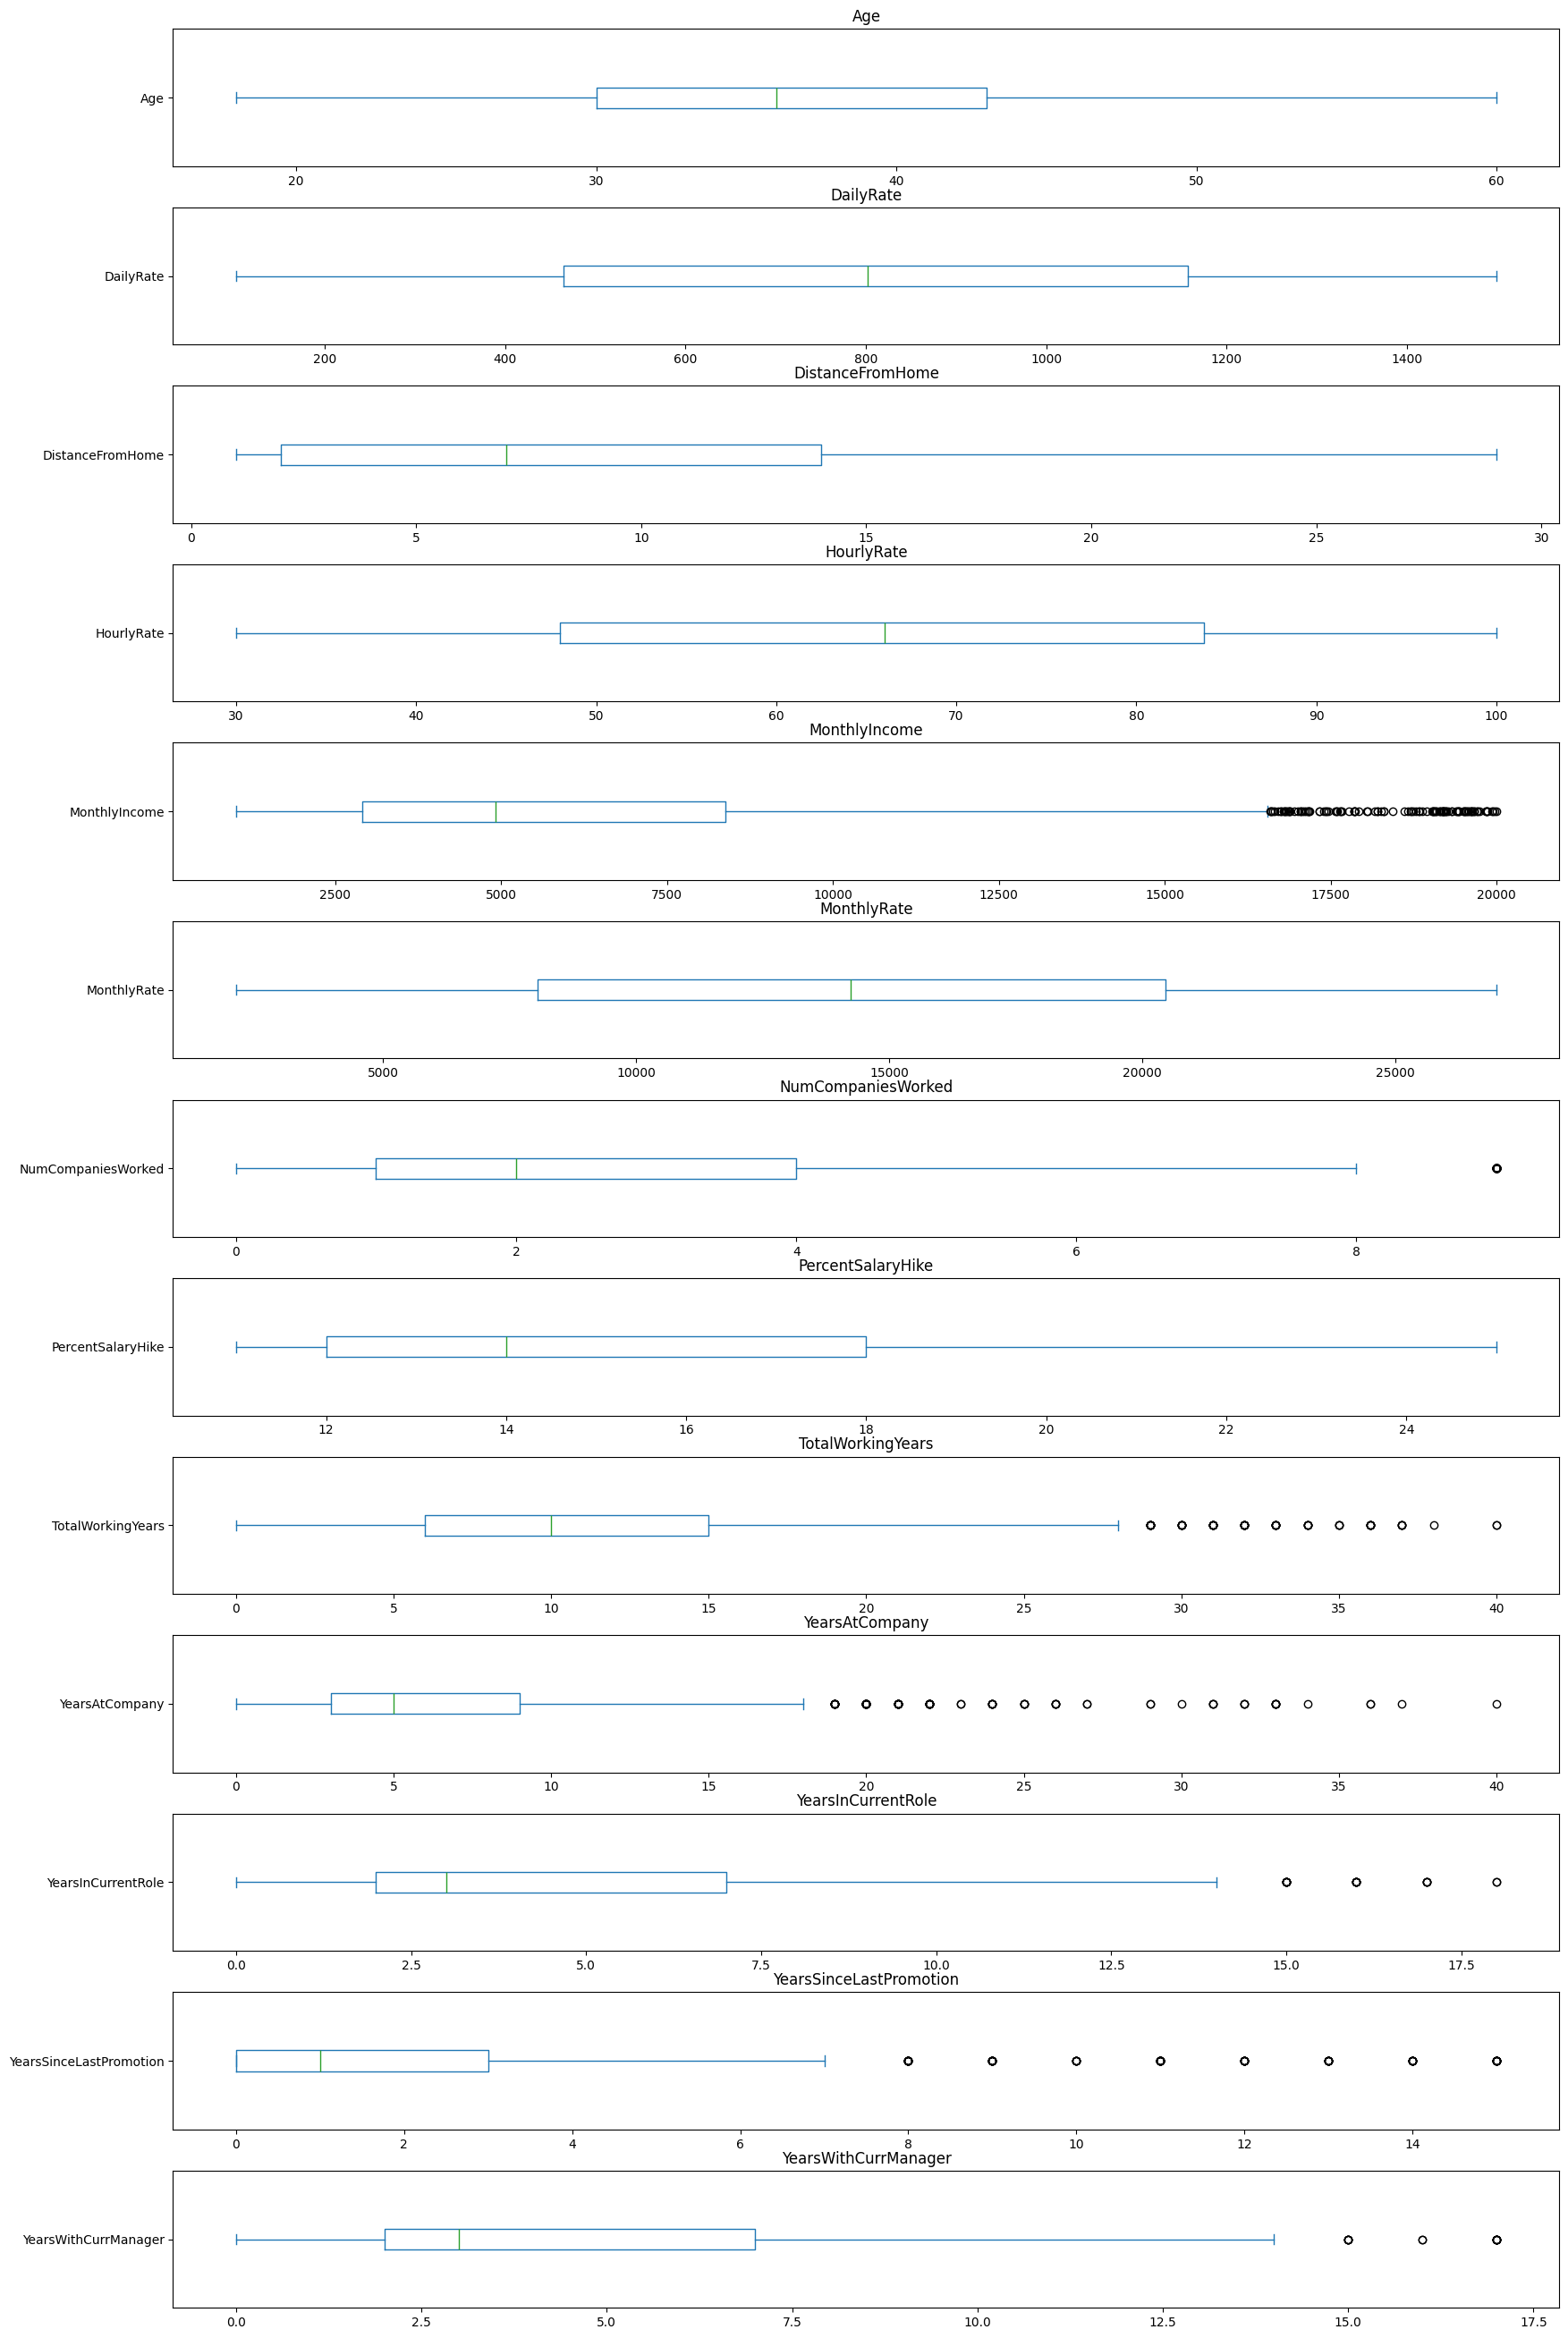

In [9]:
# 독립변수 - Numerical Data
plt.figure(figsize=(20,len(list_numerical_column)*2))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.2)
for column_name in list_numerical_column:
    plt.subplot(len(list_numerical_column),1,x)
    x = x+1
    df[column_name].plot(kind='box', vert=False)
    plt.title(column_name)

plt.show()

### 2. Feature Selection (Preprocessing) - Numerical

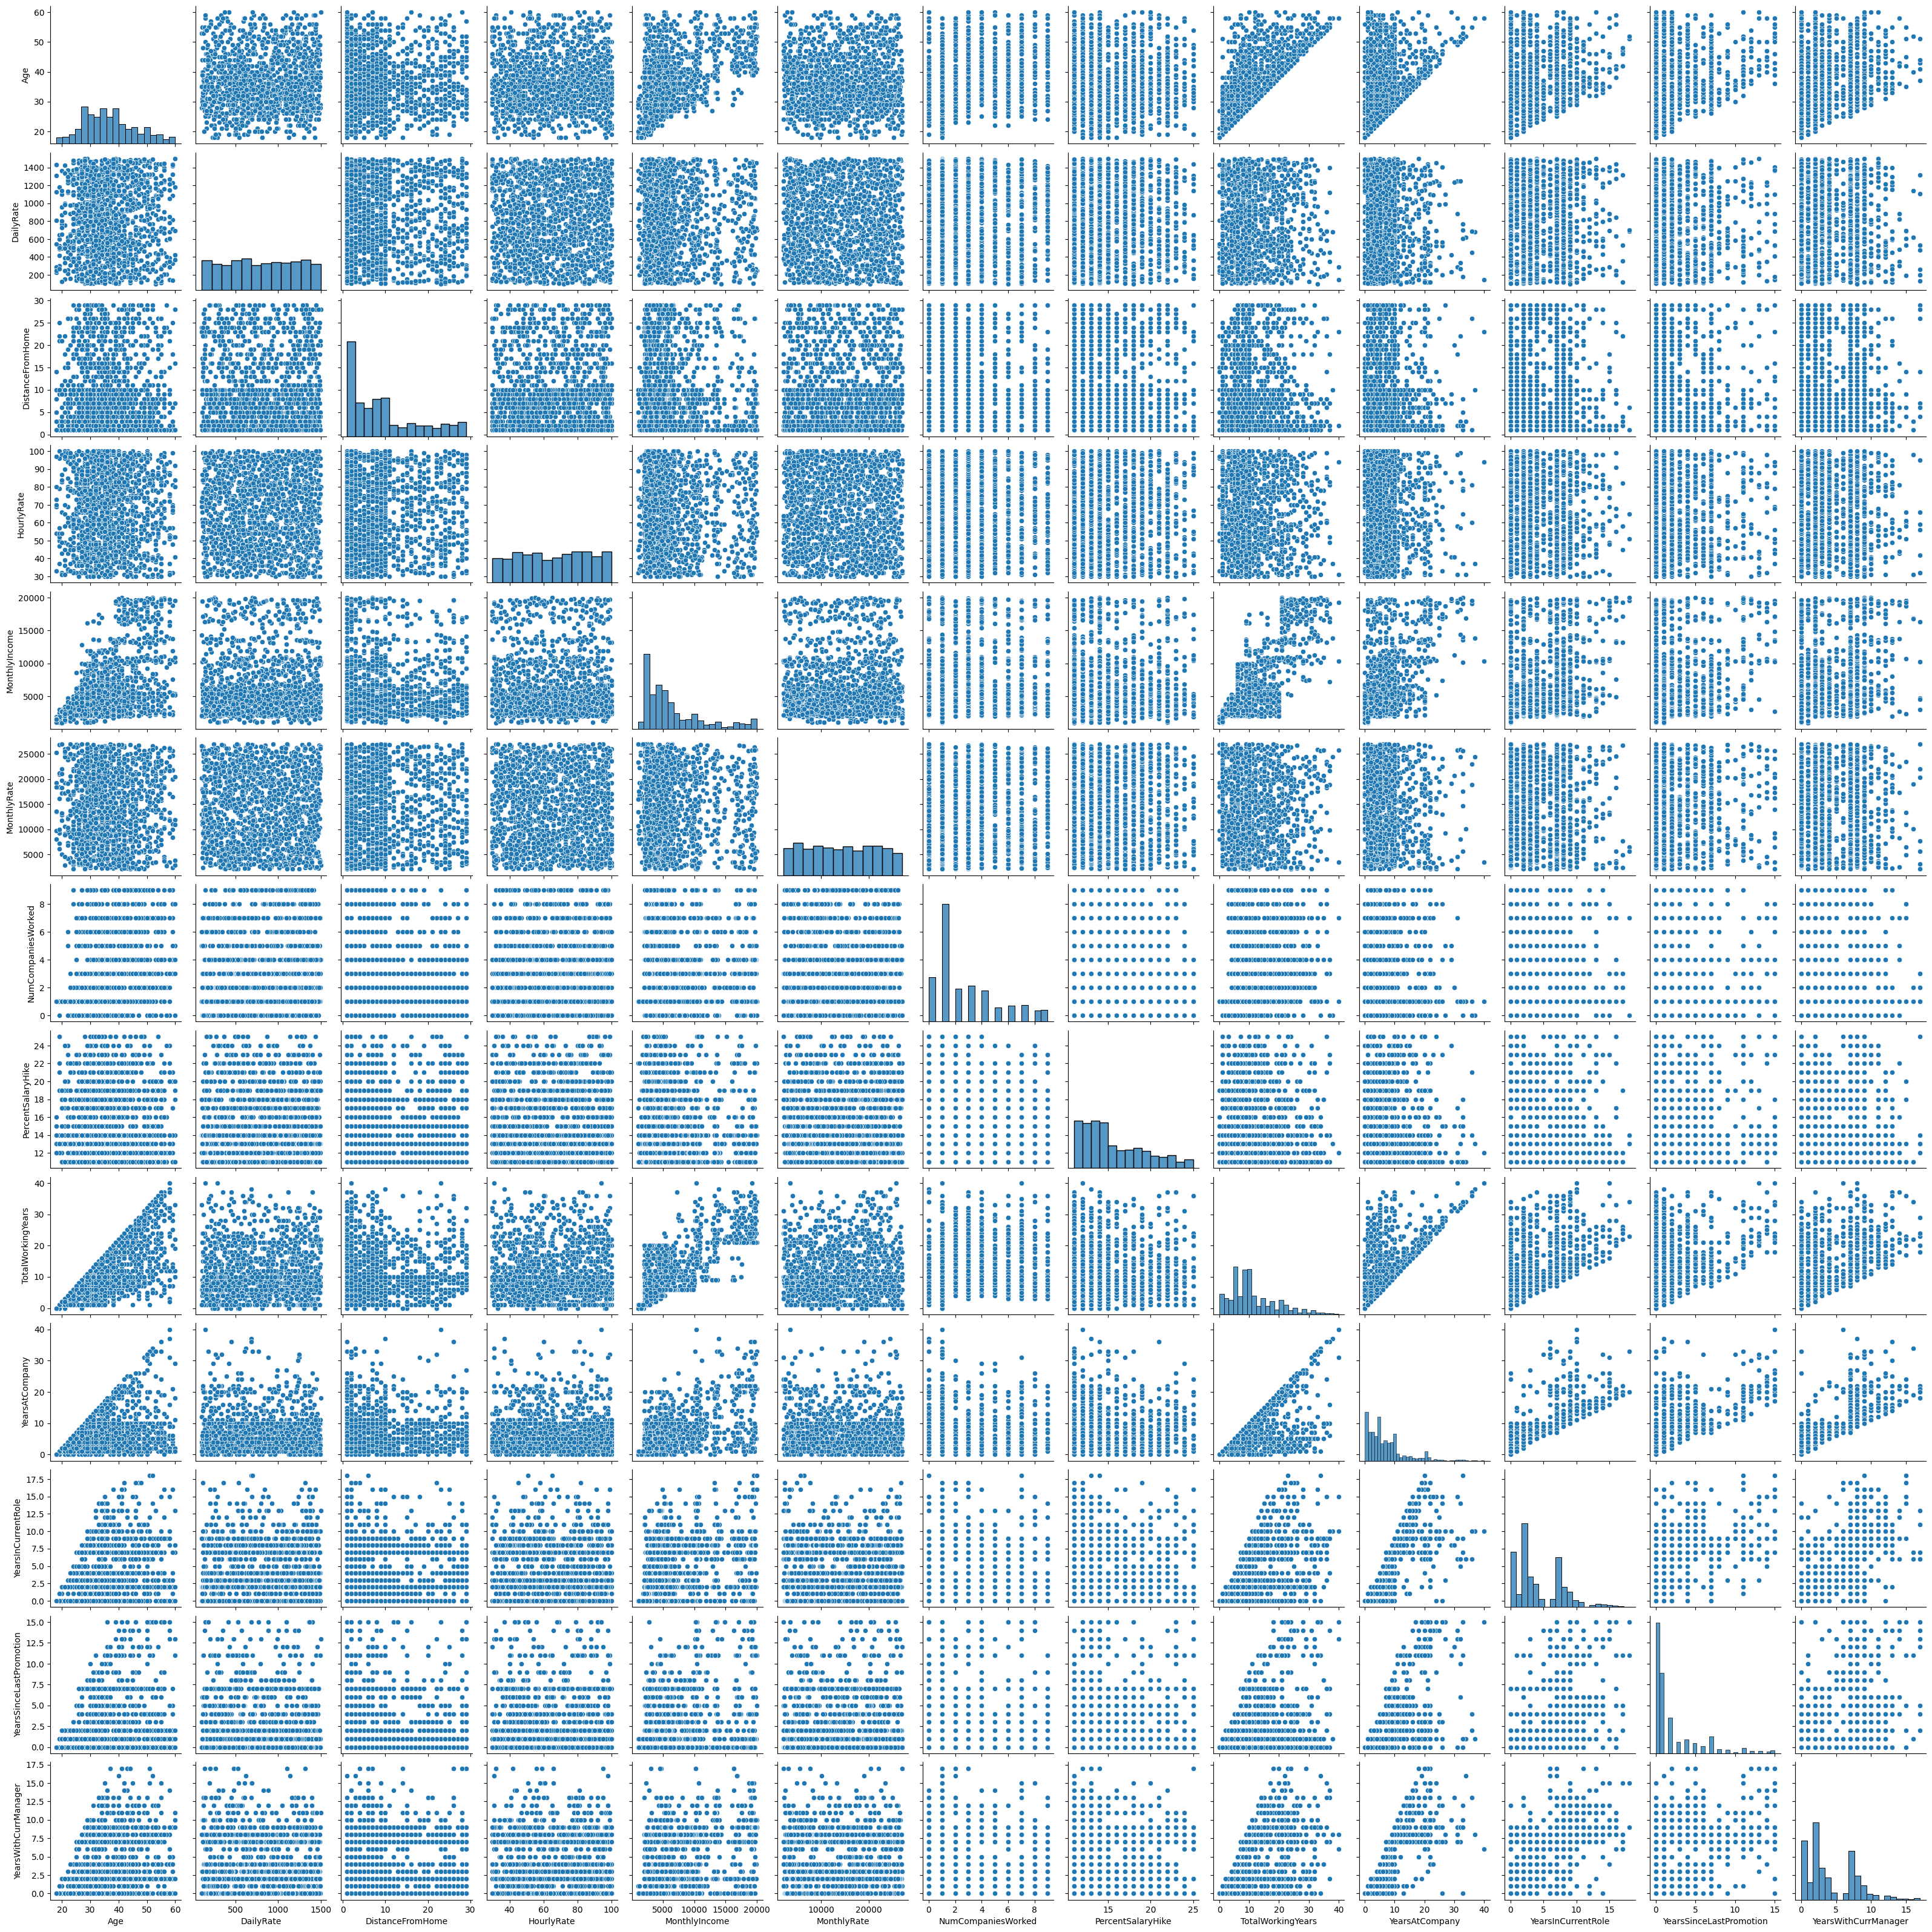

In [10]:
# n차 관계 유무 확인
sns.pairplot(data=df.loc[:, list_numerical_column])

<Axes: >

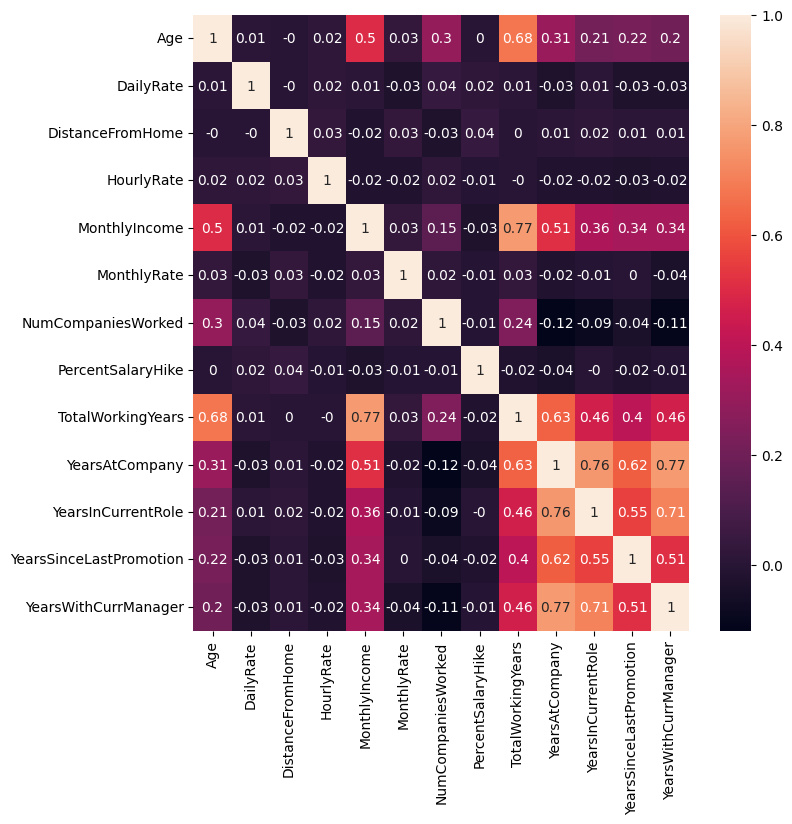

In [11]:
# 선형관계 확인
df_corr = df[list_numerical_column].corr()
df_corr = df_corr.apply(lambda x: round(x,2))
plt.figure(figsize=(8,8))
sns.heatmap(df_corr, annot=True)

In [12]:
df_corr = df_corr.replace(1,0)
df_corr = df_corr[df_corr>0.3].dropna(axis=0, how='all')
list_numerical_column = list(df_corr.index)
print(list_numerical_column)

['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [13]:
# VIF 분석
def caculate_vif(df_target):
  vif = pd.DataFrame()
  vif['VIF_Factor'] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  vif['Feature'] = df_target.columns
  return vif

max_factor = 100
while(max_factor>12):
    df_vif = df[list_numerical_column].copy()
    tmp_rst = caculate_vif(df_vif)
    max_factor = tmp_rst['VIF_Factor'].max()
    if(max_factor<12): break
    remove_cols = list(tmp_rst.sort_values(by='VIF_Factor', ascending=False).head(1)['Feature'])
    list_numerical_column = [col for col in list_numerical_column if col not in remove_cols]
    print('remove:', remove_cols, max_factor)

tmp_rst

VIF_Factor                  Feature
0    5.553758                      Age
1    7.185017            MonthlyIncome
2   11.053398        TotalWorkingYears
3    9.928214           YearsAtCompany
4    6.254712       YearsInCurrentRole
5    2.424309  YearsSinceLastPromotion
6    6.325258     YearsWithCurrManager

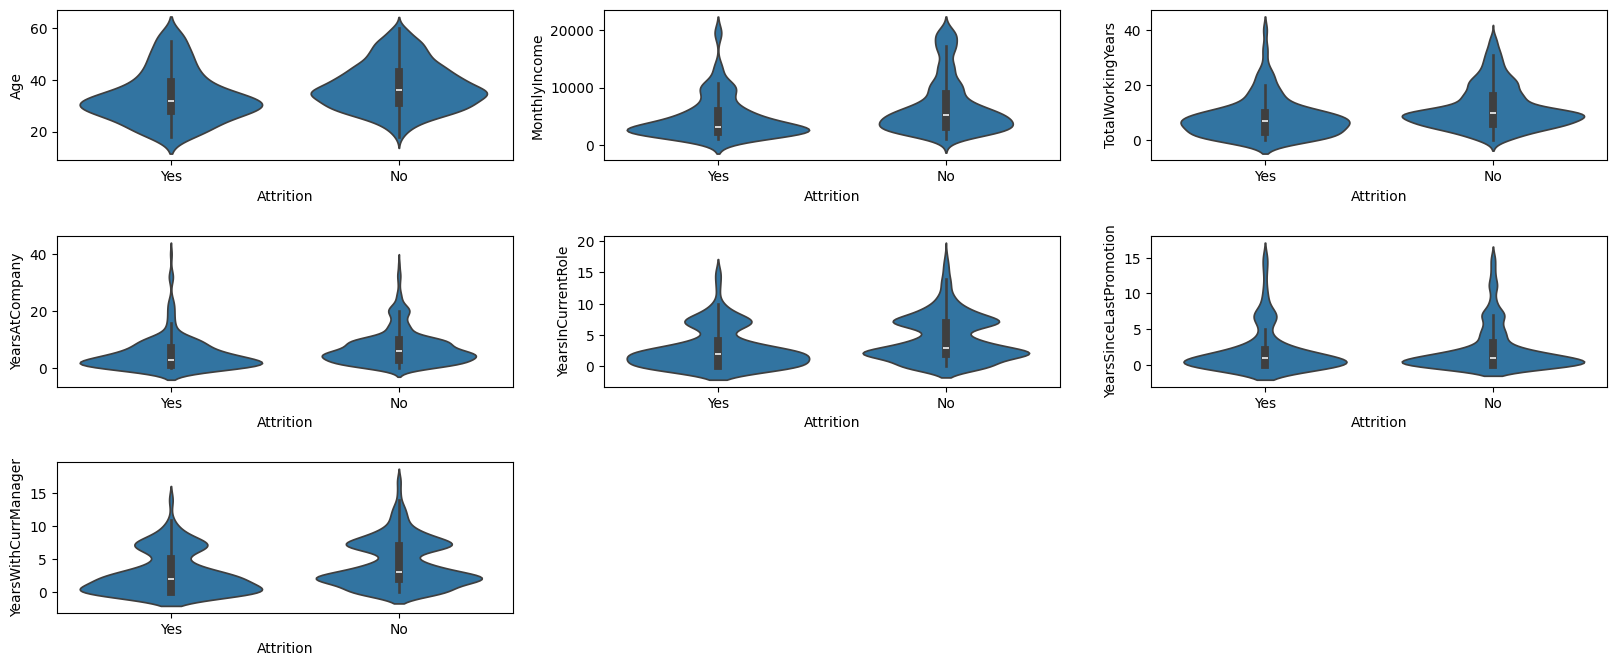

In [14]:
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.2)
for column_name in list_numerical_column:
    plt.subplot(9,3,x)
    x = x + 1
    sns.violinplot(data=df,x=target_column,y=column_name)
plt.show()

### 2. Feature Selection (Preprocessing) - Categorical

In [15]:
# 독립성 검정
tmp_rst = []
list_meaningful_column_by_chi = []
for column_name in list_categorical_column:
  if(column_name==target_column):continue
  statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
  if pvalue <= 0.05:
    list_meaningful_column_by_chi.append(column_name)
  tmp_rst.append([column_name, statistic,pvalue])
print("all categorical columns : ", len(list_categorical_column))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

list_categorical_column = list_meaningful_column_by_chi

pd.DataFrame(tmp_rst, columns=['col_name','statistics','pvalue'])

all categorical columns :  17
selected columns by chi :  13 ['BusinessTravel', 'Department', 'EducationField', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance']


col_name  statistics        pvalue
0             BusinessTravel   24.182414  5.608614e-06
1                 Department   10.796007  4.525607e-03
2                  Education    3.073961  5.455253e-01
3             EducationField   16.024674  6.773980e-03
4    EnvironmentSatisfaction   22.503881  5.123469e-05
5                     Gender    1.116967  2.905724e-01
6             JobInvolvement   28.492021  2.863181e-06
7                   JobLevel   72.529013  6.634685e-15
8                    JobRole   86.190254  2.752482e-15
9            JobSatisfaction   17.505077  5.563005e-04
10             MaritalStatus   46.163677  9.455511e-11
11                  OverTime   87.564294  8.158424e-21
12         PerformanceRating    0.000155  9.900745e-01
13  RelationshipSatisfaction    5.241068  1.549724e-01
14          StockOptionLevel   60.598301  4.379390e-13
15     TrainingTimesLastYear   15.146451  1.914773e-02
16           WorkLifeBalance   16.325097  9.725699e-04

In [16]:
print('최종 Numerical Feature:', list_numerical_column)
print('최종 Categorical Feature:', list_categorical_column)
print('Feature 수:', len(list_categorical_column)+len(list_numerical_column))

최종 Numerical Feature: ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
최종 Categorical Feature: ['BusinessTravel', 'Department', 'EducationField', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance']
Feature 수: 20


### 3. Modeling - data

In [17]:
Y = df[target_column]
X = df[list_numerical_column+list_categorical_column]

In [18]:
le_encoder = LabelEncoder()
Y_encoded = le_encoder.fit_transform(Y)
Y_encoded

array([1, 0, 1, ..., 0, 0, 0], shape=(1470,))

In [21]:
X_preprocessed = pd.get_dummies(X)
X_preprocessed.head()

Age  MonthlyIncome  TotalWorkingYears  YearsAtCompany  YearsInCurrentRole  \
0   41           5993                  8               6                   4   
1   49           5130                 10              10                   7   
2   37           2090                  7               0                   0   
3   33           2909                  8               8                   7   
4   27           3468                  6               2                   2   

   YearsSinceLastPromotion  YearsWithCurrManager  BusinessTravel_Non-Travel  \
0                        0                     5                      False   
1                        1                     7                      False   
2                        0                     0                      False   
3                        3                     0                      False   
4                        2                     2                      False   

   BusinessTravel_Travel_Frequently  BusinessTravel_Travel_Rarely  ...  \
0                             False                          True  ...   
1                              True                         False  ...   
2                             False                          True  ...   
3                              True                         False  ...   
4                             False                          True  ...   

   TrainingTimesLastYear_1  TrainingTimesLastYear_2  TrainingTimesLastYear_3  \
0                    False                    False                    False   
1                    False                    False                     True   
2                    False                    False                     True   
3                    False                    False                     True   
4                    False                    False                     True   

   TrainingTimesLastYear_4  TrainingTimesLastYear_5  TrainingTimesLastYear_6  \
0                    False                    False                    False   
1                    False                    False                    False   
2                    False                    False                    False   
3                    False                    False                    False   
4                    False                    False                    False   

   WorkLifeBalance_1  WorkLifeBalance_2  WorkLifeBalance_3  WorkLifeBalance_4  
0               True              False              False              False  
1              False              False               True              False  
2              False              False               True              False  
3              False              False               True              False  
4              False              False               True              False  

[5 rows x 65 columns]

In [32]:
X_train, X_validation, y_train, y_validation = train_test_split(X_preprocessed, Y_encoded, stratify=Y_encoded)

# imabalanced data -> balancing
sme = SMOTEENN(random_state=42)
X_sme_sampling, y_sme_sampling = sme.fit_resample(X_train, y_train)

### 3. Modeling

In [47]:
rf_clf = RandomForestClassifier(max_depth = 4, n_estimators=5)
rf_clf.fit(X_train, y_train)
y_prd = rf_clf.predict_proba(X_validation)[:,-1]
score = roc_auc_score(y_validation, y_prd)

print('# imbalanced data - model의 feature importance')
print("roc_auc_score : ", score)

fi_list = []
for n,v in zip(rf_clf.feature_names_in_, rf_clf.feature_importances_):
    fi_list.append([n,v])

pd.DataFrame(fi_list, columns=['feature','importances']).sort_values(by='importances', ascending=False).head(10)

# imbalanced data - model의 feature importance
roc_auc_score :  0.7656464264165431


feature  importances
2      TotalWorkingYears     0.103193
1          MonthlyIncome     0.093168
0                    Age     0.092723
49          OverTime_Yes     0.083733
48           OverTime_No     0.077678
50    StockOptionLevel_0     0.062528
27            JobLevel_1     0.062092
12      Department_Sales     0.032162
41     JobSatisfaction_1     0.030624
6   YearsWithCurrManager     0.029492

In [48]:
rf_clf = RandomForestClassifier(max_depth = 4, n_estimators=5)
rf_clf.fit(X_sme_sampling, y_sme_sampling)
y_prd = rf_clf.predict_proba(X_validation)[:,-1]
score = roc_auc_score(y_validation, y_prd)

print('# balanced data - model의 feature importance')
print("roc_auc_score : ", score)

fi_list = []
for n,v in zip(rf_clf.feature_names_in_, rf_clf.feature_importances_):
    fi_list.append([n,v])

pd.DataFrame(fi_list, columns=['feature','importances']).sort_values(by='importances', ascending=False).head(10)

# balanced data - model의 feature importance
roc_auc_score :  0.6881136525697987


feature  importances
1               MonthlyIncome     0.266038
4          YearsInCurrentRole     0.120111
2           TotalWorkingYears     0.084371
6        YearsWithCurrManager     0.071692
0                         Age     0.054972
27                 JobLevel_1     0.051192
63          WorkLifeBalance_3     0.041011
21  EnvironmentSatisfaction_3     0.037456
5     YearsSinceLastPromotion     0.031016
20  EnvironmentSatisfaction_2     0.027660

In [51]:
# Grid Search - 최적 parameter 찾기
cv = 3
n_jobs = -1

hyper_params_xgb = {"criterion" : ["gini", "entropy"],
                    'max_depth': [4, 6, 8, 10],
                    'max_features': [3,5,10],
                    'n_estimators': [10, 15, 20, 25]}

rf_clf = RandomForestClassifier(max_depth = 4, n_estimators=5)
grid_cv_opt = GridSearchCV(rf_clf, param_grid = hyper_params_xgb, cv = cv, n_jobs = n_jobs)
grid_cv_opt.fit(X_train, y_train)

print('# imbalanced data - model tuning')
print('best model hyper-parameter : ', grid_cv_opt.best_params_)
y_prd = grid_cv_opt.predict_proba(X_validation)[:,-1]
score = roc_auc_score(y_validation, y_prd)
print("roc_auc_score : ", score)

# imbalanced data - model tuning
best model hyper-parameter :  {'criterion': 'gini', 'max_depth': 8, 'max_features': 10, 'n_estimators': 15}
roc_auc_score :  0.7251933519828863


### 마무리
- 2에서 사용했던 feature engineering의 로직을 사용하여 쉽게 전처리 진행
- RandomForest 특성으로 학습할 때 마다 모델의 score가 달라짐